Similarity between frame 0 and frame 1: 0.9931317280967834
Similarity between frame 1 and frame 2: 0.9972978622489427
Similarity between frame 2 and frame 3: 0.9979443042389463
Similarity between frame 3 and frame 4: 0.9976827115381012
Similarity between frame 4 and frame 5: 0.9967040507140711
Similarity between frame 5 and frame 6: 0.9969338151917178
Similarity between frame 6 and frame 7: 0.9981853740448225
Similarity between frame 7 and frame 8: 0.999364571631412
Similarity between frame 8 and frame 9: 0.9950297673746036
Similarity between frame 9 and frame 10: 0.9988846331149602
Similarity between frame 10 and frame 11: 0.9972143641254236
Similarity between frame 11 and frame 12: 0.9975441112996013
Similarity between frame 12 and frame 13: 0.9990646946824194
Similarity between frame 13 and frame 14: 0.9979631641938653
Similarity between frame 14 and frame 15: 0.9995709567165484
Similarity between frame 15 and frame 16: 0.994917700492582
Similarity between frame 16 and frame 17: 0.9

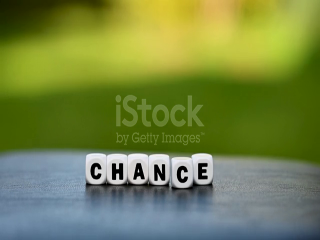

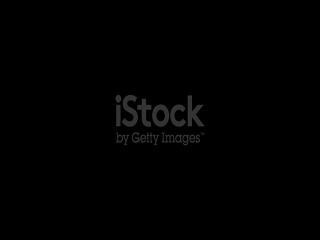

Scene cut 2: between frame 206 and frame 207 with similarity score: 0.9041715355091132


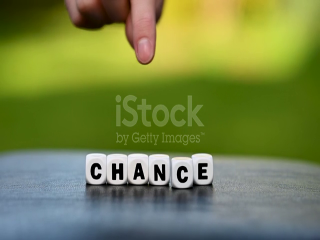

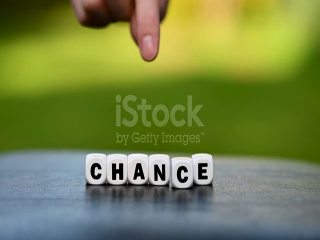

Scene cut 3: between frame 246 and frame 247 with similarity score: 0.949299920614606


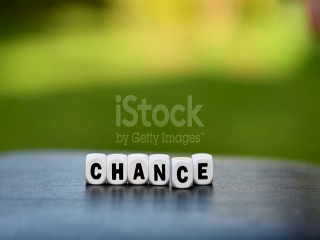

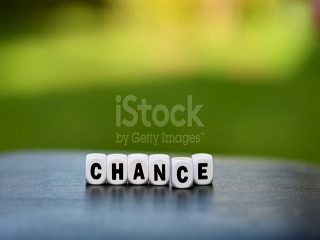

Scene cut 4: between frame 249 and frame 250 with similarity score: 0.961875862429578


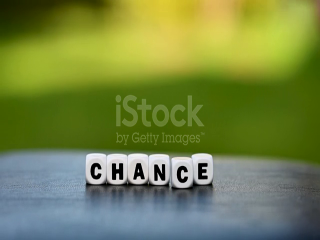

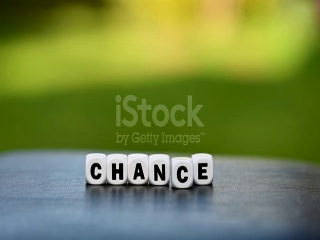

Scene cut 5: between frame 215 and frame 216 with similarity score: 0.9620846309198446


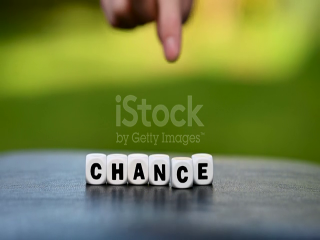

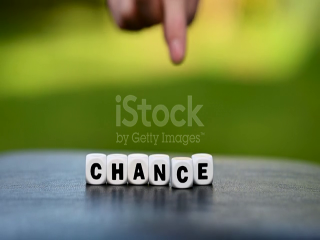

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def load_video(video_path, resize_dim=(320, 240)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame for faster processing
        resized_frame = cv2.resize(frame, resize_dim)
        frames.append(resized_frame)

    cap.release()
    return frames

def convert_to_hsv(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

def noise_detection(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    noise_mask = cv2.absdiff(frame, blurred)
    return noise_mask

def histogram_comparison(frame1, frame2):
    hist1 = cv2.calcHist([frame1], [0, 1], None, [256, 256], [0, 256, 0, 256])
    hist2 = cv2.calcHist([frame2], [0, 1], None, [256, 256], [0, 256, 0, 256])
    cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)


    similarity_score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity_score

def sobel_edge_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale before Sobel
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.magnitude(sobel_x, sobel_y)
    return np.uint8(edges)

def find_least_similarity_cuts(similarity_scores, frames, top_n=5):
    # Get the indices of the least similarity scores (lowest values indicate scene cuts)
    least_similar_indices = np.argsort(similarity_scores)[:top_n]

    print(f"Top {top_n} scene cut frames (by least similarity):")
    for i, idx in enumerate(least_similar_indices):
        print(f"Scene cut {i+1}: between frame {idx} and frame {idx+1} with similarity score: {similarity_scores[idx]}")

        # Display the two consecutive frames where the scene cut occurs
        cv2_imshow(frames[idx])
        cv2_imshow(frames[idx+1])
        cv2.waitKey(1000)  # Wait for a key press to display next set of frames

    return least_similar_indices

def process_video(video_path, hsv_directory, noise_directory, edge_directory, top_n_cuts=5, resize_dim=(320, 240)):
    if not os.path.exists(hsv_directory):
        os.makedirs(hsv_directory)
    if not os.path.exists(noise_directory):
         os.makedirs(noise_directory)
    if not os.path.exists(edge_directory):
         os.makedirs(edge_directory)

    frames = load_video(video_path, resize_dim=resize_dim)
    hsv_frames = []
    noise_frames = []
    edge_frames = []
    similarity_scores = []

    for idx, frame in enumerate(frames):
        # Step 2: Convert each frame into HSV
        hsv_frame = convert_to_hsv(frame)
        hsv_frames.append(hsv_frame)
        cv2.imwrite(os.path.join(hsv_directory, f'hsv_frame_{idx}.png'), hsv_frame)

        # Step 3: Detect noise
        noise_frame = noise_detection(frame)
        noise_frames.append(noise_frame)
        cv2.imwrite(os.path.join(noise_directory, f'noise_frame_{idx}.png'), noise_frame)

        # Step 4: Perform histogram comparison with the previous frame
        if idx > 0:
            similarity = histogram_comparison(frames[idx-1], frames[idx])
            similarity_scores.append(similarity)
            print(f'Similarity between frame {idx-1} and frame {idx}: {similarity}')

        # Step 5: Perform edge detection
        edge_frame = sobel_edge_detection(frame)
        edge_frames.append(edge_frame)
        cv2.imwrite(os.path.join(edge_directory, f'edge_frame_{idx}.png'), edge_frame)

    # Step 6: Find least similarity cuts and display the frames
    if len(similarity_scores) > 0:
        least_similar_indices = find_least_similarity_cuts(similarity_scores, frames, top_n_cuts)

        # Optionally, save the frames at the scene cut points for analysis
        for i, idx in enumerate(least_similar_indices):
            cv2.imwrite(os.path.join(hsv_directory, f'scene_cut_frame_{i+1}frame{idx}.png'), frames[idx])
            cv2.imwrite(os.path.join(hsv_directory, f'scene_cut_frame_{i+1}frame{idx+1}.png'), frames[idx+1])


video_path = r"/content/video.mp4"
hsv_directory = r"/content/hsv_frames"
noise_directory = r"/content/noise_frames"
edge_directory = r"/content/edge_frames"
process_video(video_path, hsv_directory, noise_directory, edge_directory, top_n_cuts=5, resize_dim=(320, 240))